## Определение стоимости автомобилей

<a id="up"></a>

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

### Задачи исследования

### [1. Загрузите и подготовьте данные. ](#1)

### [2. Обучите разные модели. Для каждой попробуйте различные гиперпараметры.](#2)

### [3. Проанализируйте скорость работы и качество моделей.](#3)
##### Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку `LightGBM` и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

### Описание данных

`Признаки`

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

`Целевой признак`
- Price — цена (евро)

<a id="1"></a>

### 1. Загрузим файл и изучим общую информацию, подготовим данные.

In [1]:
import pandas as pd    
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('autos.csv')
except Exception as e:
    print(e)
    df = pd.read_csv('/datasets/autos.csv')

pd.set_option('display.max_columns', None) 
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [5]:
df.duplicated().sum()

4

##### Вывод:
- важные признаки: `Price`,`VehicleType`,`RegistrationYear`,`Gearbox`,`Power`,`Model`,`Kilometer`,`FuelType`,`Brand`,`NotRepaired`, остальные признаки не влияют на то, чтобы быстро узнать рыночную стоимость своего автомобиля;
- имеются дубликаты, большое количество пропусков, нулевые значения.

##### Проведем предоработку данных, рассмотрим важные признаки.

In [6]:
import sweetviz as sv

In [7]:
df = df[['Price',            # оставим важные признаки
         'VehicleType', 
         'RegistrationYear',
         'Gearbox',
         'Power',
         'Model',
         'Kilometer',
         'FuelType',
         'Brand',
         'NotRepaired']]
         
                 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [8]:
report = sv.analyze([df, "Permit Logs"])

                                             |     | [  0%]   00:00 -> (? left)

In [11]:
report.show_html('common analysis.html')

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [12]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [13]:
df = df.drop_duplicates().reset_index(drop = True) # удаляем дубликаты, не жалко их мало

In [14]:
#  целевой признак price, пропусков данных нет, но есть цена равная нулю, восстановить по среднему было бы некоректно,
# так как признак целевой и это напрямую повлияет на прогноз.

print("Колличество объявлений с нулевой ценой:",len(df.loc[df['Price'] == 0]))

Колличество объявлений с нулевой ценой: 8904


In [15]:
df = df.loc[df['Price'] != 0] # избавимся от нулевой цены

1 20000


array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

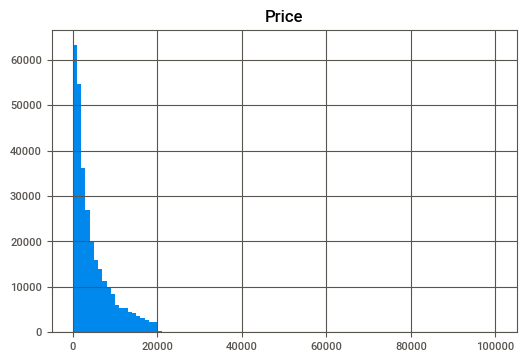

In [16]:
print(df['Price'].min(),df['Price'].max())
df[['Price']].hist(bins=100,range = (0, 100000))

In [17]:
df['Price'].quantile([.05, 0.95])

0.05      350.0
0.95    14900.0
Name: Price, dtype: float64

In [18]:
df = df.query('350 <= Price') # установим цену от 350(euro) и выше

In [19]:
df.fillna({'Gearbox':'manual', # тип коробки передач ставим механика, т.к. в априори идет механика
           'NotRepaired':'yes',  # пропуски заменим на да, скре всего не аполнена, т.к. авто без ремонта
           'VehicleType':'unknown'}, # пропуски запишем как неизвестно
            inplace=True)
df.isna().sum()

Price                   0
VehicleType             0
RegistrationYear        0
Gearbox                 0
Power                   0
Model               14916
Kilometer               0
FuelType            24139
Brand                   0
NotRepaired             0
dtype: int64

1000 9999


array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

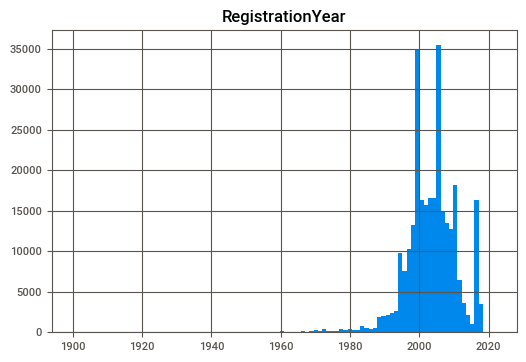

In [20]:
print(df['RegistrationYear'].min(),df['RegistrationYear'].max())
df[['RegistrationYear']].hist(bins=100,range = (1900, 2022))

In [21]:
df = df.query('1959 < RegistrationYear < 2017') # взяли актуальный период без выбросов
df['RegistrationYear'].describe() 

count    273340.000000
mean       2002.859234
std           6.763974
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

In [22]:
print("Колличество объявлений с некорректной мощностью:",len(df.loc[(df['Power'] > 1000) | (df['Power'] <= 0)]))

Колличество объявлений с некорректной мощностью: 25170


In [23]:
# заменим пропуски мощности по среднему по моели авто, остальные удаляем
df.loc[(df['Power'] > 1000) | (df['Power'] <= 0), 'Power'] = None
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df = df.loc[~df['Power'].isna()]
df['Power'] = df['Power'].astype('int64')

In [24]:
# удалим пропуски по моделям
df = df.loc[~df['Model'].isna()]

In [25]:
# пропуски тип топлива на среднее по моделям
df['FuelType'] = df['FuelType'].fillna(df.groupby('Model')['FuelType'].transform(lambda x: x.value_counts().idxmax()))

In [26]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

##### Преобразуем категориальные признаки с большим колличеством категорий техникой `Ordinal Encoding`.

In [27]:
df_reg = df

In [28]:
encoder = OrdinalEncoder()
encoder.fit(df) 
df_ordinal = pd.DataFrame(encoder.transform(df), columns=df.columns)
df_ordinal.reset_index()
df.loc[:,['Brand', 'Model']] = df_ordinal.loc[:,['Brand', 'Model']]


In [29]:
df = df.fillna(0)

In [30]:
df['Brand'] = df['Brand'].astype(int)
df['Model'] = df['Model'].astype(int)

##### Признаки `VehicleType`, `Gearbox`, `FuelType`, `NotRepaired` закодируем `one-hot encoding`.

In [31]:
def ohe(df, column):
    data = pd.get_dummies(df[column], prefix=column, drop_first=True)
    df = df.drop(column, axis=1)
    return df.join(data)

In [32]:
df = ohe(df, 'VehicleType')
df = ohe(df, 'Gearbox')
df = ohe(df, 'FuelType')
df = ohe(df, 'NotRepaired')

In [33]:
# разобьем данные на тестовую и валидационную выборки и на признаки и целевой признак
target = df['Price']
features = df.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

In [34]:
features_train

,RegistrationYear,Power,Model,Kilometer,Brand,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,VehicleType_wagon,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,NotRepaired_yes
175485,2000,50,95,150000,20,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
132621,1992,75,122,150000,24,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
32742,2010,150,29,70000,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
111799,1990,69,140,150000,30,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
128180,2012,110,173,90000,37,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100967,2002,306,166,125000,20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
157802,2001,50,59,100000,20,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1
154329,2011,105,73,150000,11,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0
91252,2006,150,129,150000,24,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0


##### стандартизируем численные признаки и преобразованные техникой `Ordinal Encoding`.

In [35]:
numeric = ['RegistrationYear', 'Power', 'Model', 'Kilometer', 'Brand']

In [36]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric]) 
print(features_train.head())

        RegistrationYear     Power     Model  Kilometer     Brand  \
175485         -0.455898 -1.346471  0.048344   0.607727  0.211944   
132621         -1.675084 -0.879783  0.403005   0.607727  0.497691   
32742           1.068085  0.520281 -0.818607  -1.528095 -1.145353   
111799         -1.979881 -0.991788  0.639446   0.607727  0.926311   
128180          1.372881 -0.226420  1.072921  -0.994140  1.426368   

        VehicleType_convertible  VehicleType_coupe  VehicleType_other  \
175485                        0                  0                  0   
132621                        0                  0                  0   
32742                         0                  0                  0   
111799                        0                  0                  0   
128180                        0                  0                  0   

        VehicleType_sedan  VehicleType_small  VehicleType_suv  \
175485                  0                  1                0   
132621          

#### Вывод:
- удалены пропуски, дубликаты, выбросы, некоректные значения в признаках заполнены на основе имеющейся инфрмации или удалены
- отобрали признаки, необходимые для построения моделей
- категориальные признаки преобразованы с помощью `one-hot encoding`
- признак с большим колличеством категорий закодирован техникой `Ordinal Encoding`.
- разделили данные на тестовую и обучающую выборки, стандартизированны

<a id="2"></a>

### 2. Обучим модели.

##### Linear Regression

In [37]:
%%time
lmodel = LinearRegression()
lmodel.fit(features_train, target_train)

Wall time: 1.45 s


LinearRegression()

In [38]:
%%time
preds_lmodel = lmodel.predict(features_test)

Wall time: 23.6 ms


In [39]:
mse_lmodel = mean_squared_error(target_test, preds_lmodel)
print("RMSE для линейной модели на тестовой выборке:", round((mse_lmodel) ** 0.5, 2))

RMSE для линейной модели на тестовой выборке: 2953.53


##### Регрессия Ridge

In [40]:
%%time

rmodel = Ridge()
hyperparams = [{'solver':['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}]
rmodel = GridSearchCV(rmodel, hyperparams, scoring='neg_mean_squared_error')
rmodel.fit(features_train, target_train)
print(rmodel.best_params_)

{'solver': 'svd'}
Wall time: 4.86 s


In [41]:
%%time
preds_rmodel = rmodel.predict(features_test)

Wall time: 20.6 ms


In [42]:
mse_rmodel = mean_squared_error(target_test, preds_rmodel)
print("RMSE для Ridge модели на тестовой выборке:", round((mse_rmodel) ** 0.5, 2))

RMSE для Ridge модели на тестовой выборке: 2953.53


##### Регрессия Decision Tree Regresso

In [43]:
%%time

trmodel = DecisionTreeRegressor(criterion='mse', 
                              max_depth=8, 
                              random_state=12345) 
trmodel.fit(features_train, target_train)

Wall time: 847 ms


DecisionTreeRegressor(max_depth=8, random_state=12345)

In [44]:
%%time
preds_trmodel = trmodel.predict(features_test)

Wall time: 17 ms


In [45]:
mse_trmodel = mean_squared_error(target_test, preds_trmodel)
print("RMSE для Decision Tree Regresso модели на тестовой выборке:", round((mse_trmodel) ** 0.5, 2))

RMSE для Decision Tree Regresso модели на тестовой выборке: 2153.03


##### Регрессия Cat Boost Regressor

In [46]:
numerical_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer']

In [47]:
categorical_features = [col for col in list(features_train.columns) if col not in numerical_features]

- в связи с тем, что CatBoostRegressor принимает только целые числа или строки в категориях, пересобрал признаки
- так же попробовал оставить категориальные признаки без one-hot encoding, качество немного выросло на CatBoost и LGBM, время обработки увеличилось

In [48]:
df_reg.loc[:,['VehicleType','Gearbox', 'Brand', 'FuelType', 'NotRepaired']] = df_ordinal.loc[:,['VehicleType','Gearbox', 'Brand', 'FuelType', 'NotRepaired']]
catfeatures = df_reg.drop('Price', axis=1)
cattarget = df_reg['Price']
catfeatures_train, catfeatures_test, cattarget_train, cattarget_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [49]:
numericcat = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(catfeatures_train[numericcat])
catfeatures_train[numericcat] = scaler.transform(catfeatures_train[numericcat])
catfeatures_test[numericcat] = scaler.transform(catfeatures_test[numericcat]) 

In [50]:
%%time
catmodel = CatBoostRegressor(learning_rate=0.5, random_state=12345, verbose=False) 
catmodel.fit(catfeatures_train, target_train, cat_features=categorical_features)

Wall time: 2min 11s


In [51]:
%%time

cat_predict = catmodel.predict(catfeatures_test)

Wall time: 773 ms


In [52]:
mse_catmodel = mean_squared_error(target_test, cat_predict)
print("RMSE для Cat Boost Regressor модели на тестовой выборке:", round((mse_catmodel) ** 0.5, 2))

RMSE для Cat Boost Regressor модели на тестовой выборке: 1861.69


##### Регрессия LGBM Regressor

In [53]:
%%time

lgbmmodel = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=12345,
                      cat_features=categorical_features)
lgbmmodel.fit(features_train, target_train)

Wall time: 2.13 s


LGBMRegressor(cat_features=['Model', 'Brand', 'VehicleType_convertible',
                            'VehicleType_coupe', 'VehicleType_other',
                            'VehicleType_sedan', 'VehicleType_small',
                            'VehicleType_suv', 'VehicleType_unknown',
                            'VehicleType_wagon', 'Gearbox_manual',
                            'FuelType_electric', 'FuelType_gasoline',
                            'FuelType_hybrid', 'FuelType_lpg', 'FuelType_other',
                            'FuelType_petrol', 'NotRepaired_yes'],
              num_leaves=100, random_state=12345)

In [54]:
%%time

lgbm_predict = lgbmmodel.predict(features_test)

Wall time: 367 ms


In [55]:
mse_lgbmmodel = mean_squared_error(target_test, lgbm_predict)
print("RMSE для LGBMRegressor модели на тестовой выборке:", round((mse_lgbmmodel) ** 0.5, 2))

RMSE для LGBMRegressor модели на тестовой выборке: 1865.13


#### Вывод:
- обучены модели

Проведены измерения:

- времени обучения
- времени предсказания моделей
- качества предсказания по метрике RMSE

<a id="3"></a>

### 3. Анализ моделей.

In [59]:
data = [["1.45 ms", "23.6 ms", 2953.53],
        ["4.86 ms", "20.6 ms", 2953.53],
        ["847 ms", "17 ms", 2153.03],
        ["2min 11s", "773 ms", 1861.69],
        ["2.13 s", "367 ms", 1865.13]]
model = ["Linear Regression", "Ridge", "DecisionTreeRegresso", "CatBoostRegressor", "LGBMRegressor"]

In [60]:
pd.DataFrame(data=data, index=model, columns=["fit_time", "predict_time", "RMSE"])

,fit_time,predict_time,RMSE
Linear Regression,1.45 ms,23.6 ms,2953.53
Ridge,4.86 ms,20.6 ms,2953.53
DecisionTreeRegresso,847 ms,17 ms,2153.03
CatBoostRegressor,2min 11s,773 ms,1861.69
LGBMRegressor,2.13 s,367 ms,1865.13


#### Вывод:
- наилучшее качество получилось у модели `CatBoostRegressor`, время обучения самое долгое - 2min 11s
- `LGBMRegressor` предсказала немного хуже, но обучилась быстрее на данных гиперпараметрах - 2.13 s

##### [к оглавлению](#up)